 create a strategy and generate factsheet

In [2]:
# packages
import numpy as np
import pandas as pd
from typing import Tuple, List
from enum import Enum
import yfinance as yf
import qis
from qis import TimePeriod, PortfolioData
from qis.portfolio.reports.config import fetch_default_report_kwargs



In [4]:
# define strategy universe data
def fetch_universe_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    """
    define custom universe with asset class grouping
    """
    universe_data = dict(SPY='Equities',
                         QQQ='Equities',
                         EEM='Equities',
                         TLT='Bonds',
                         IEF='Bonds',
                         LQD='Credit',
                         HYG='HighYield',
                         GLD='Gold')
    tickers = list(universe_data.keys())
    group_data = pd.Series(universe_data)  # for portfolio reporting
    prices = yf.download(tickers=tickers, start=None, end=None, ignore_tz=True)['Adj Close'][tickers]
    prices = prices.asfreq('B', method='ffill')  # make B frequency
    benchmark_prices = prices[['SPY', 'TLT']]
    return prices, benchmark_prices, group_data

In [5]:
# define and implement strategy which computes allocation weights and returns backtested portfolio data

def generate_volparity_portfolio(prices: pd.DataFrame,
                                 group_data: pd.Series,
                                 time_period: TimePeriod = None,
                                 span: int = 60,
                                 vol_target: float = 0.15,
                                 rebalancing_costs: float = 0.0010  # per volume traded
                                 ) -> PortfolioData:
    ra_returns, weights, ewm_vol = qis.compute_ra_returns(returns=qis.to_returns(prices=prices, is_log_returns=True),
                                                          span=span,
                                                          vol_target=vol_target)
    weights = weights.divide(weights.sum(1), axis=0)

    if time_period is not None:
        weights = time_period.locate(weights)

    volparity_portfolio = qis.backtest_model_portfolio(prices=prices,
                                                       weights=weights,
                                                       rebalancing_costs=rebalancing_costs,
                                                       weight_implementation_lag=1,
                                                       ticker='VolParity')
    volparity_portfolio.set_group_data(group_data=group_data, group_order=list(group_data.unique()))
    return volparity_portfolio

In [7]:
# fetch strategy universe
prices, benchmark_prices, group_data = fetch_universe_data()


[*********************100%%**********************]  8 of 8 completed


In [9]:
# define reporting period and run strategy backtest
time_period = TimePeriod('31Dec2005', '16Oct2024')
portfolio_data = generate_volparity_portfolio(prices=prices,
                                              group_data=group_data,
                                              time_period=time_period,
                                              span=30,
                                               vol_target=0.15,
                                               rebalancing_costs=0.001)

[*********************100%%**********************]  1 of 1 completed


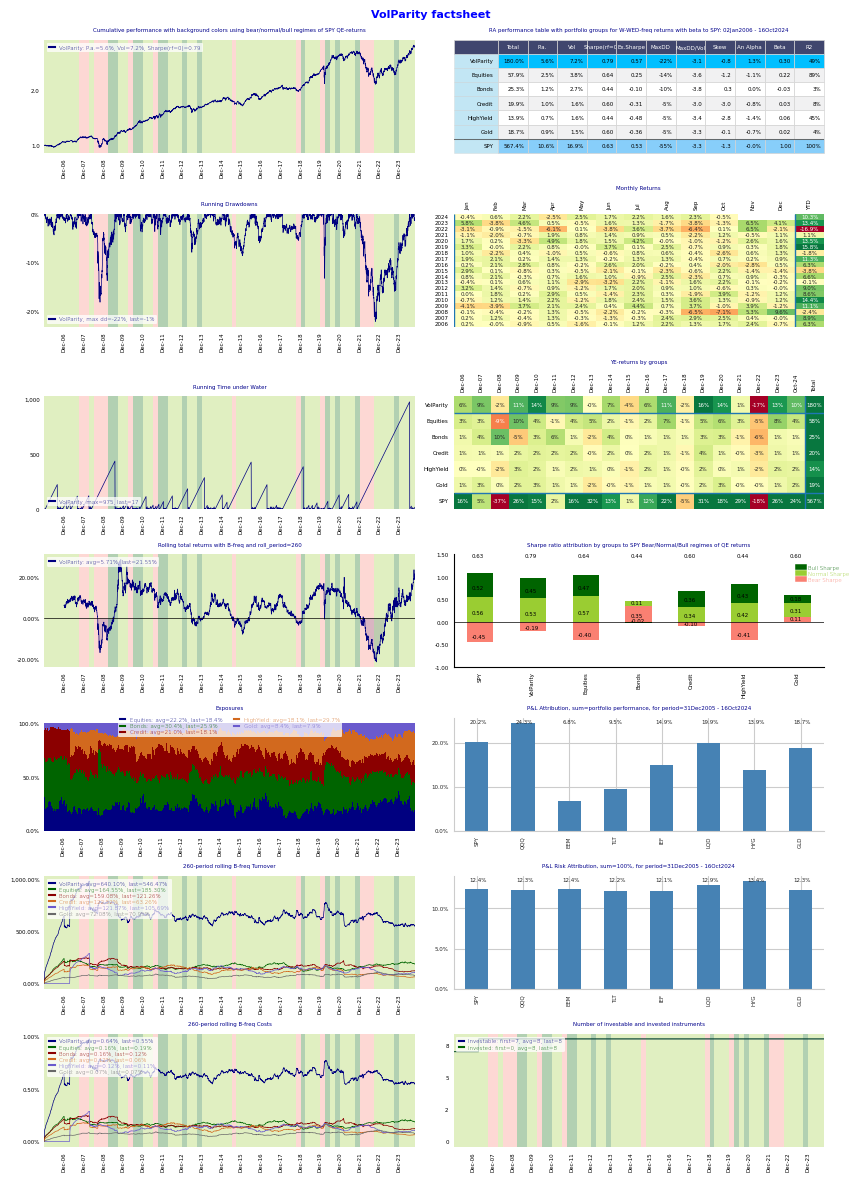

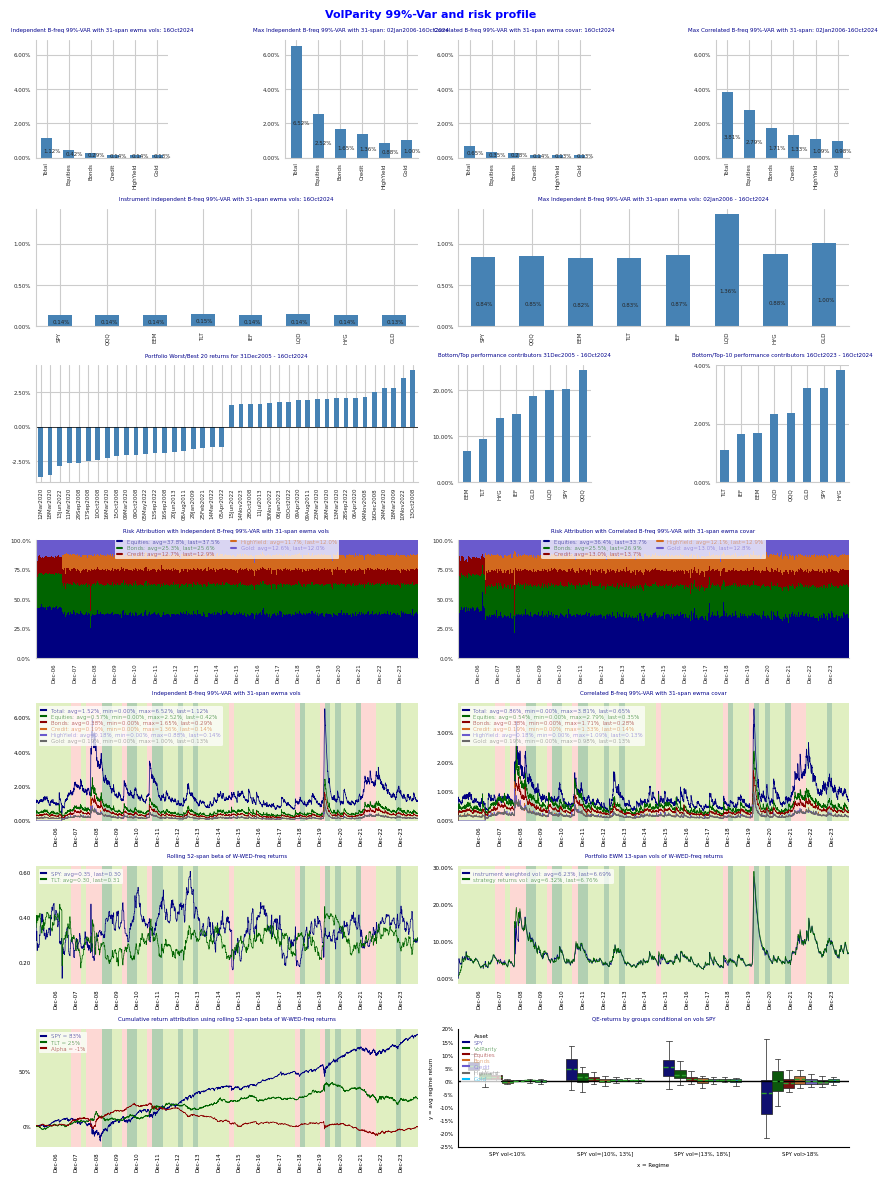

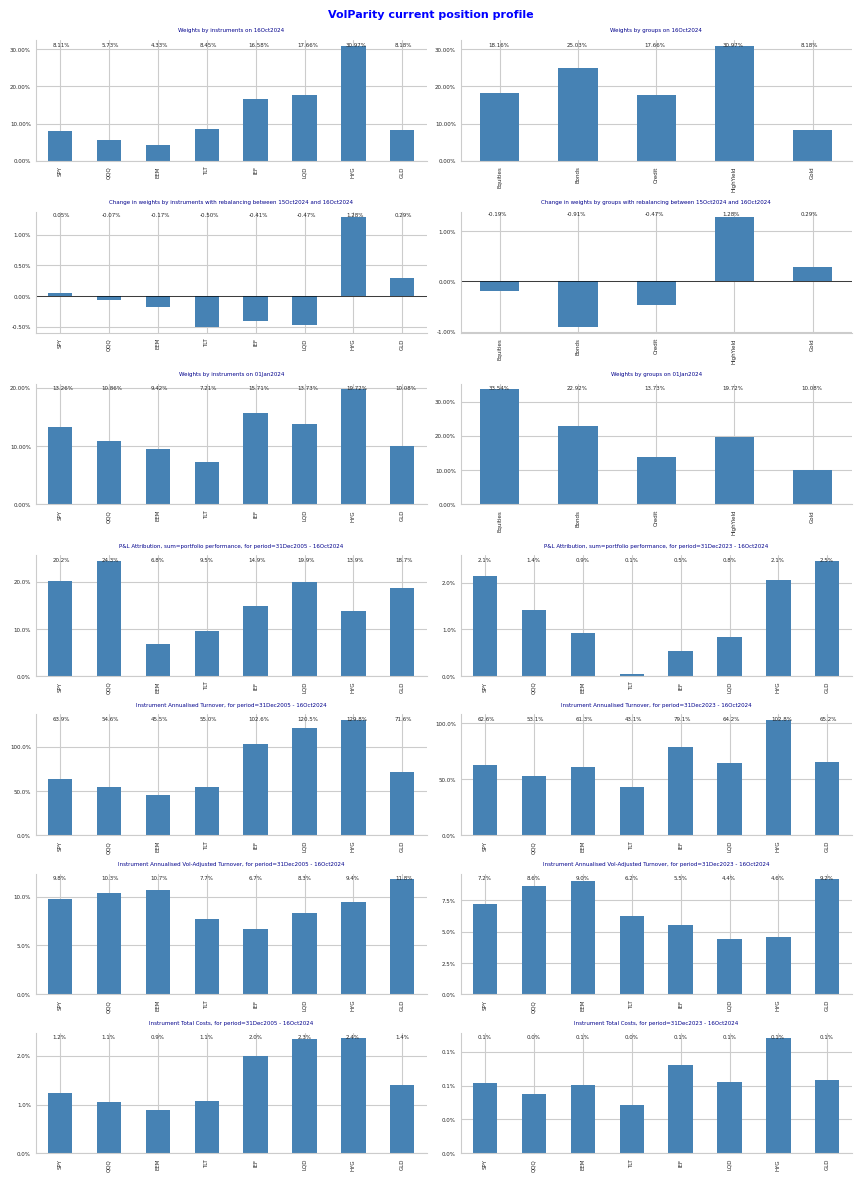

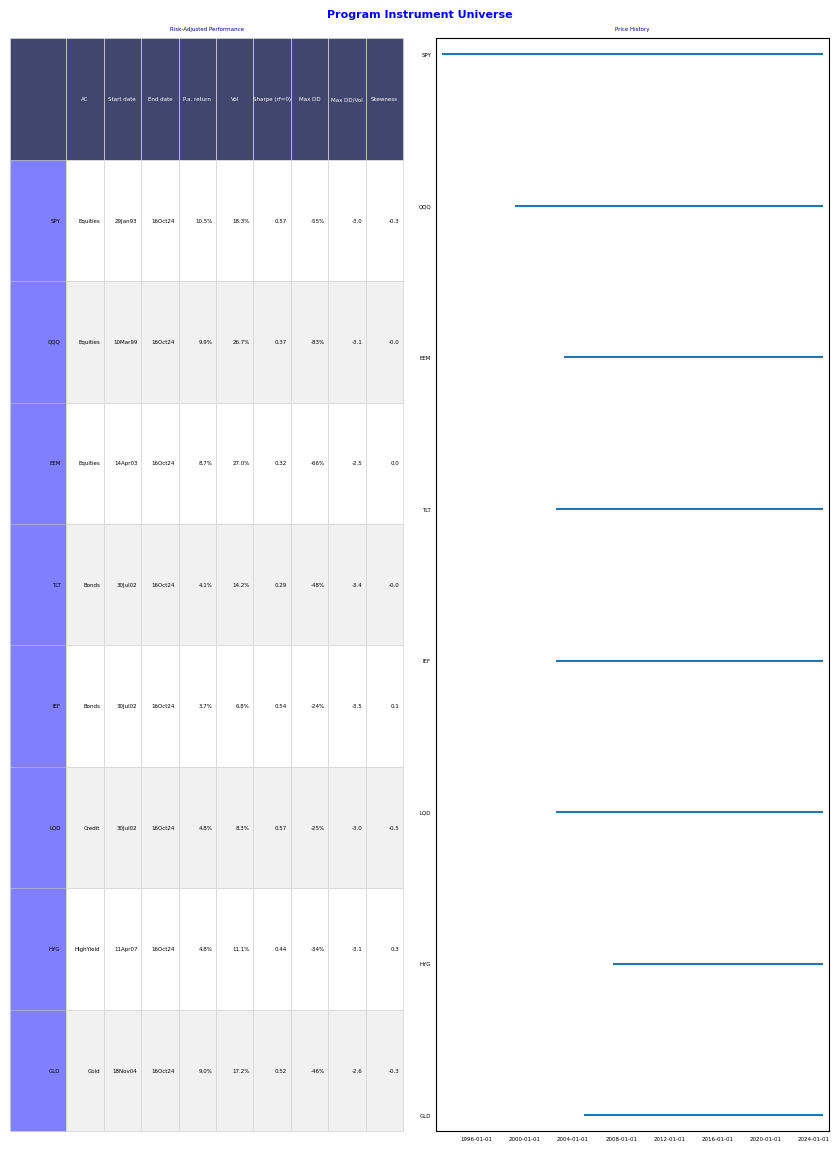

In [11]:
# generate strategy report
figs = qis.generate_strategy_factsheet(portfolio_data=portfolio_data,
                                               benchmark_prices=benchmark_prices,
                                               time_period=time_period,
                                               add_current_position_var_risk_sheet=True,
                                               add_weights_turnover_sheet=True,
                                               add_grouped_exposures=False,
                                               add_grouped_cum_pnl=False,
                                               add_weight_change_report=False,
                                               add_current_signal_report=False,
                                               add_instrument_history_report=True,
                                               **fetch_default_report_kwargs(time_period=time_period))